The steps we take for our analysis are basically

1. Classify sentences into topics e.g. service, fees, registration
2. Classify sentences within each topic as positive or negative
3. Count positive/negative within each topic
4. Perform linear/multi-linear regression between pos/neg in each topic, and
the rating associated the text that sentence belongs to.

In [33]:
import pandas as pd
import json

# Create new csv with labels 
csv_files = ["robinhood.csv", "webull.csv", "etoro.csv"]
li = []
for filename in csv_files:
    df = pd.read_csv(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
data = frame.loc[:, ["content", "score", "reviewId"]]
#! Have to use str.len() becahse len(data["Content"] just gives you no. rows in data frame)
new_data = data.loc[(data["content"].str.len() > 50)] 
new_data.shape



(7811, 3)

In [34]:
# Break each review into sentences
reviews = new_data.loc[:, ["content"]]
sentenced_reviews = {"content": [], "rating": [], "reviewId": []}
new_data["sentences"] = new_data["content"].str.split(".");
new_data.head(10)

for index, content in new_data.iterrows():    
    for sentence in content["sentences"]:
        sentenced_reviews["content"].append(sentence)
        sentenced_reviews["rating"].append(content["score"])
        sentenced_reviews["reviewId"].append(content["reviewId"])

reviews = pd.DataFrame(sentenced_reviews)
reviews = reviews.loc[(reviews["content"].str.len() > 20)] # Only get sentences longer than about 5 words

/tmp/ipykernel_9951/811496203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["sentences"] = new_data["content"].str.split(".");


In [35]:
# Store the dataframe into csv and then we label about 100 sentences for training purposes
reviews["label"] = "NA"
reviews["isen"] = False;
reviews.head(100)

# Remove all non-english reviews
import spacy
from spacy_langdetect import LanguageDetector
from spacy.language import Language

def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("language_detector", name="language_detector", last=True)


def is_english(row):
    row["isen"] = (nlp(row["content"])._.language["language"] == "en")
    return row #! Must return the row for it to add to new dataframe

english_reviews = reviews.apply(is_english, axis="columns")
english_reviews = english_reviews.loc[(english_reviews["isen"] == True)]
english_reviews.head(100)

,content,rating,reviewId,label,isen
0,"I once wrote my reviews here, how robinhood ha...",1,748c2355-d884-463b-8c9a-46d9e8cfa1ea,NA,True
3,"If you know exactly what you want to buy, you...",5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
4,But if you aren't the best at keeping up with...,5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
5,You even get a weekly newsletter that recaps ...,5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
7,Good app Very bad horrible email customer supp...,1,7444c5dc-8395-4890-9c47-5f690fb6f69b,NA,True
...,...,...,...,...,...
145,"As an end user, just know RH is marketing 2 d...",1,43e8fd81-f74d-4148-beac-f70a3954b674,NA,True
146,"I've seen 1 day earlier than your normal pay,...",1,43e8fd81-f74d-4148-beac-f70a3954b674,NA,True
148,They help you create your portfolio based on ...,5,5031206f-2cd5-4d44-8e82-09c06d041371,NA,True
151,I've been using this app for a few years now a...,1,d3e37291-84d3-41d5-838b-1b3e8122484a,NA,True


In [36]:
# Create sample dataset to label

# Define convention in terms of topics used
# NA - no topic assigned -> used for prediction 
# C - Customer service
# F - Fees
# R - Registration/Verification Issues
# D - Deposit/Withdrawals
# A - App itself e.g. user interface, ease of use, other features.
# T - Trust and company reputation
# O - Other issues
#! Grab review ID
# Sample 20 from each rating category and perform random topic labelling
long_reviews = english_reviews.loc[(reviews["content"].str.len() > 40)]
long_reviews["rating"].value_counts()
long_reviews.head(100)



,content,rating,reviewId,label,isen
0,"I once wrote my reviews here, how robinhood ha...",1,748c2355-d884-463b-8c9a-46d9e8cfa1ea,NA,True
3,"If you know exactly what you want to buy, you...",5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
4,But if you aren't the best at keeping up with...,5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
5,You even get a weekly newsletter that recaps ...,5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True
7,Good app Very bad horrible email customer supp...,1,7444c5dc-8395-4890-9c47-5f690fb6f69b,NA,True
...,...,...,...,...,...
181,Thanks to Robinhood this has been a great way ...,4,8b4058c2-daae-4cf5-897f-fa409856b6f1,NA,True
183,I keep getting email notification even though ...,2,2fc30803-becd-453f-a795-ec6eeb71ddfe,NA,True
184,All I get is bad news from Robinhood about al...,2,2fc30803-becd-453f-a795-ec6eeb71ddfe,NA,True
185,I just want to forget about it but Robinhood ...,2,2fc30803-becd-453f-a795-ec6eeb71ddfe,NA,True


In [37]:
#! DO NOT RUN THIS - Accidentally overwrote labels of training dataset.
# training_set = []
# for rating, count in long_reviews["rating"].value_counts().items():
#     training_set.append(long_reviews.loc[long_reviews.rating == rating].sample(20))
# training_set = pd.concat(training_set, axis=0, ignore_index=True)
# training_set.head(100)
# training_set.to_csv("training.csv")


In [38]:
# Create new long_reviews with fixed indexes so we can transform it
new_long = long_reviews.copy()
new_long = new_long.reset_index()
new_long = new_long.drop(columns="index")
new_long.tail(100)


,content,rating,reviewId,label,isen
13232,Good for someone just checking out trading cry...,3,21a9a39a-3d64-4ded-8889-d2fe417757fa,NA,True
13233,Limited crypto options but more than Robinhoo...,3,21a9a39a-3d64-4ded-8889-d2fe417757fa,NA,True
13234,I enjoy it but can't find many of the crypto ...,3,21a9a39a-3d64-4ded-8889-d2fe417757fa,NA,True
13235,"Withdrawn money went missing, also taking mone...",1,63b85b3e-3a7d-4e0f-bd5c-cfe63a3e4ee6,NA,True
13236,what an absolute piece of **** this app is,1,eeb59903-943a-4ff6-a43a-b6c1ce9b2aea,NA,True
...,...,...,...,...,...
13327,and I become The Gay Pride symbol so I will m...,5,bdaa0b97-d095-4a04-8e5a-3b68a40d0c22,NA,True
13328,Good apps for investment but it's lack evertin...,4,35bc4a50-a347-44d8-bdcb-0e259b024e5b,NA,True
13329,Great way to be conned by Toro Telemarketing i...,1,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,NA,True
13330,Eugen Sima fled country when he as portfolio m...,1,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,NA,True


In [39]:
# Convert each sentence into Bow before fitting model
# Text cleaning function we want ot apply to each document
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

training_set = pd.read_csv("training.csv")

# TODO: Lower case all the words
def text_cleaning(a):
    remove_punctuation = [char for char in a if char not in string.punctuation]
    remove_punctuation = "".join(remove_punctuation)
    #! Probably might want to reduce words to only stems to remove duplicates
    return [word.lower() for word in remove_punctuation.split() if word.lower() not in stopwords.words("english")]


bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(new_long["content"])
bow_transformer.vocabulary_
training_bow = bow_transformer.transform(training_set["content"])
#! Need to createa new transformer for long_bow
# bow_transformer = CountVectorizer(analyzer=text_cleaning).fit(long_reviews["content"])
long_bow = bow_transformer.transform(new_long["content"]);
print(training_set)

    Unnamed: 0                                            content  rating  \
0            0   I have been trying to set up my account again...       1   
1            1     Can't check my balance now, really bad service       1   
2            2  withdrawal is nightmare, if you are a profitab...       1   
3            3   5% for this transaction and it is so complicated       1   
4            4   their choice to go public means they have to ...       1   
..         ...                                                ...     ...   
95          95  I have just downloaded this app and have not u...       4   
96          96  easy to stake ethereum, doing part ethereum an...       4   
97          97  Exciting and motivating and informative Xx C t...       4   
98          98       Now it's a must for me to track my portfolio       4   
99          99    Original post 2017: Great app to start out with       4   

   label  isen  Unnamed: 5  Unnamed: 6  
0      C  True         NaN        

In [40]:
print(training_set["label"])
print(training_bow)

0     C
1     C
2     D
3     F
4     T
     ..
95    O
96    O
97    O
98    O
99    O
Name: label, Length: 100, dtype: object
  (0, 469)	1
  (0, 1283)	1
  (0, 6720)	1
  (0, 6785)	1
  (0, 7552)	1
  (0, 8780)	1
  (1, 1051)	1
  (1, 1059)	1
  (1, 1580)	1
  (1, 1717)	1
  (1, 6777)	1
  (1, 7545)	1
  (2, 5708)	1
  (2, 6530)	1
  (2, 8657)	1
  (2, 9452)	1
  (3, 280)	1
  (3, 1980)	1
  (3, 8687)	1
  (4, 833)	1
  (4, 1741)	1
  (4, 2088)	1
  (4, 3903)	1
  (4, 4684)	1
  (4, 5241)	1
  :	:
  (97, 3134)	1
  (97, 3232)	1
  (97, 3526)	1
  (97, 3534)	1
  (97, 3776)	1
  (97, 4350)	2
  (97, 4511)	1
  (97, 4805)	1
  (97, 5136)	1
  (97, 5565)	1
  (97, 5871)	2
  (97, 7089)	1
  (97, 8009)	1
  (97, 8393)	1
  (97, 9307)	1
  (97, 9358)	1
  (98, 5594)	1
  (98, 6365)	1
  (98, 8647)	1
  (99, 138)	1
  (99, 819)	1
  (99, 3969)	1
  (99, 5959)	1
  (99, 6388)	1
  (99, 8009)	1


In [41]:
#! Do not use NA as a label -> pandas interprets it as null
training_set["label"].isnull().any()

False

In [42]:
# Whilst we have successfully classified alot of the sentences/texts, we realise
# That the classification is biased towards the sample i.e. most reviews concern A
# in sample and so we get more As
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(training_bow, training_set["label"]) 

#! To make predictions - features/vocab of training set must == vocab of prediction set
all_predictions = model.predict(long_bow)
pred_df = pd.Series(name="prediction", data=all_predictions)
pred_df.value_counts()
pred_df.tail(100)

new_long = pd.concat([new_long, pred_df], axis=1, join="outer")
new_long.tail(90)

#Reset indexes of long reviews after making copy
# long_reviews["predictions"] = pred_df
# long_reviews.tail(90)
# long_reviews.to_csv("result.csv")

,content,rating,reviewId,label,isen,prediction
13242,Virtual funds helps you understand the platfor...,3,29b69ec3-dc24-4289-8a79-b2eecf99e298,NA,True,A
13243,Charges are quite high compared to other marke...,1,992dea1c-e1cc-41e7-881f-1eb4046c74fe,NA,True,A
13244,Also the app keeps sending push notifications...,1,992dea1c-e1cc-41e7-881f-1eb4046c74fe,NA,True,A
13245,App is easy enough to use and transferring cas...,3,56dbc711-5a89-495f-954f-fd2c58ca6a0b,NA,True,A
13246,"So, once my assets appreciate I'll be moving ...",3,56dbc711-5a89-495f-954f-fd2c58ca6a0b,NA,True,A
...,...,...,...,...,...,...
13327,and I become The Gay Pride symbol so I will m...,5,bdaa0b97-d095-4a04-8e5a-3b68a40d0c22,NA,True,A
13328,Good apps for investment but it's lack evertin...,4,35bc4a50-a347-44d8-bdcb-0e259b024e5b,NA,True,A
13329,Great way to be conned by Toro Telemarketing i...,1,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,NA,True,O
13330,Eugen Sima fled country when he as portfolio m...,1,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,NA,True,A


In [43]:
new_long.loc[new_long["prediction"]=="R"].head(100)

,content,rating,reviewId,label,isen,prediction
38,They aren't even kind enough to even speak to...,1,1f6cf3f9-f2ba-4da3-a940-f81297bc688e,NA,True,R
84,"Annoying clickbait ""news"" articles can't be bl...",3,335bc43c-6a10-4234-982b-54a1a0bf32d5,NA,True,R
117,Keep it up !! And meanwhile i will keep on ho...,4,7e49780b-2421-4378-8fca-8eb04299058e,NA,True,R
193,Very difficult to learn how to use won't let m...,1,ef6cd69e-4ede-4a34-b063-6aa1e3bb765c,NA,True,R
200,"Anytime I email help center, usually within mi...",5,f670165d-13fd-40e9-ba34-091bd911514a,NA,True,R
...,...,...,...,...,...,...
3180,Xfr'd to another ee; she info's me this was a...,1,416c83a8-8807-4ff7-af4b-8db790836725,NA,True,R
3231,I can't even sign up and you don't even tell m...,1,ee9f5908-8dac-444d-a709-54fadfee0bbf,NA,True,R
3256,My phone updated and I needed help to login a...,1,7980b68d-1781-4947-9df7-0f7a5de388b6,NA,True,R
3357,I u usually have to call the call center to ask,4,88803fb7-27eb-4e62-ae0a-7fb486941e0a,NA,True,R


In [44]:
new_long.prediction.value_counts()

A    11292
O     1186
R      423
C      221
D      151
F       55
T        4
Name: prediction, dtype: int64

### Part 2 - Perform sentiment analysis on each topic and correlate with ratings
For this we will be using a pre-trained model

In [45]:
from textblob import TextBlob

def add_sentiment_cols(row):
    sent_obj = TextBlob(row["content"])
    row["sent_pol"] = sent_obj.sentiment.polarity
    row["sent_sub"] = sent_obj.sentiment.subjectivity
    return row;

new_long = new_long.apply(add_sentiment_cols, axis="columns")


In [46]:
#! Consider if you should remove based on too high subjectivity.
# Subjectivity != reliability - e.g can be subjective but true.
useful_sentiment = new_long.loc[new_long["sent_sub"] > 0.6] # < 0.4
# useful_sentiment = new_long
useful_sentiment.shape

(3960, 8)

In [47]:
useful_sentiment["prediction"].value_counts()

A    3542
O     241
R      86
C      54
D      23
F      14
Name: prediction, dtype: int64

In [48]:
# Create new DF to store whether sentiment is positive
sentiment_df = useful_sentiment.copy()
sentiment_df.reset_index(inplace=True)
sentiment_df.drop(columns="index", inplace=True)
sentiment_df["is_positive"] = sentiment_df["sent_pol"] > 0
sentiment_df.head(100)

,content,rating,reviewId,label,isen,prediction,sent_pol,sent_sub,is_positive
0,"I once wrote my reviews here, how robinhood ha...",1,748c2355-d884-463b-8c9a-46d9e8cfa1ea,NA,True,O,0.369333,0.671111,True
1,You even get a weekly newsletter that recaps ...,5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,NA,True,A,-0.022685,0.658796,False
2,Good app Very bad horrible email customer supp...,1,7444c5dc-8395-4890-9c47-5f690fb6f69b,NA,True,C,-0.403333,0.822222,False
3,Great app with an interface that is only getti...,5,ebfb12ca-6ac4-4134-bdd6-335002e8f3d2,NA,True,A,0.433333,0.750000,True
4,Invite friends and you both get stock for free,5,29e8c8e8-6f05-4b3d-898e-2b2405ae1c7d,NA,True,A,0.400000,0.800000,True
...,...,...,...,...,...,...,...,...,...
95,You can now transfer crypto into and out of R...,5,fe13949a-a8ac-42d5-9014-ffafa2e4f2e6,NA,True,A,0.400000,0.900000,True
96,Robinhood will not acknowledge the cybercrime...,1,723c4dcb-466b-41ce-8e4f-b91002bebc82,NA,True,A,0.600000,1.000000,True
97,Here is just the latest from me banging my he...,1,723c4dcb-466b-41ce-8e4f-b91002bebc82,NA,True,A,0.666667,0.900000,True
98,this app is great with instructions for beginn...,5,1ea2bbc8-78b7-4b33-ba3b-8cd145139755,NA,True,A,0.600000,0.775000,True


In [49]:
sentiment_df["is_positive"].value_counts()
sentiment_df["is_positive"].isnull().any()

False

In [50]:
# for each sentence - select items with same review id, select ones with same topic, and average sent pol.
reviews_df = {"reviewId":[], "topic":[], "sent_pol": [], "sent_sub": [], "rating": []}
for reviewId in sentiment_df["reviewId"].unique():
    for category in sentiment_df["prediction"].unique():
        reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == reviewId) & (sentiment_df["prediction"] == category)]
        if not reviewer_sent_same_topic.empty:
            sent_pol = reviewer_sent_same_topic["sent_pol"].mean()
            sent_sub = reviewer_sent_same_topic["sent_sub"].mean()
            reviews_df["reviewId"].append(reviewId)
            reviews_df["topic"].append(category)
            reviews_df["sent_pol"].append(sent_pol)
            reviews_df["sent_sub"].append(sent_pol)
            reviews_df["rating"].append(reviewer_sent_same_topic["rating"].mean())

reviews_df = pd.DataFrame(reviews_df)

In [51]:
reviews_df.head(10)


,reviewId,topic,sent_pol,sent_sub,rating
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,O,0.369333,0.369333,1.0
1,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,A,-0.022685,-0.022685,5.0
2,7444c5dc-8395-4890-9c47-5f690fb6f69b,C,-0.403333,-0.403333,1.0
3,ebfb12ca-6ac4-4134-bdd6-335002e8f3d2,A,0.433333,0.433333,5.0
4,29e8c8e8-6f05-4b3d-898e-2b2405ae1c7d,A,0.400000,0.400000,5.0
5,8185f294-3356-4fc9-8b65-b612932ee58e,A,0.099924,0.099924,5.0
6,51af13dc-3cec-4680-bfff-000ffe24d4fb,A,-1.000000,-1.000000,1.0
7,da53ca7d-fe5f-410e-ae4a-17a3a1e14119,A,0.404167,0.404167,5.0
8,752f6041-0d45-4848-ba71-6772e0bc0af5,A,-0.050000,-0.050000,3.0
9,1283b6d1-86e9-45d2-9c39-3e5be8bdd211,A,-0.002083,-0.002083,2.0


Text(0, 0.5, 'Rating')

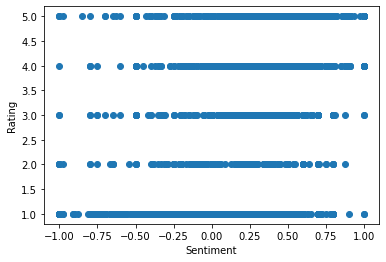

In [52]:
# See chart
import matplotlib.pyplot as plt
from importlib import reload
plt = reload(plt)
x = reviews_df[reviews_df["topic"] == "A"]["sent_pol"] #! When you don't use loc you get a series
y = reviews_df[reviews_df["topic"] == "A"]["rating"]

plt.scatter(x, y)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")


In [53]:
x = reviews_df.loc[reviews_df["topic"] == "A"].loc[:, ["sent_pol"]]
x.head(100)

,sent_pol
1,-0.022685
3,0.433333
4,0.400000
5,0.099924
6,-1.000000
...,...
110,0.616667
111,0.416667
113,0.515972
114,-0.650000


In [54]:
# Create the model and display fit
from sklearn import linear_model
model = linear_model.LinearRegression()
x = reviews_df.loc[reviews_df["topic"] == "A"].loc[:, ["sent_pol"]]
model.fit(x, y)
model.score(x, y)

0.25442910083566783

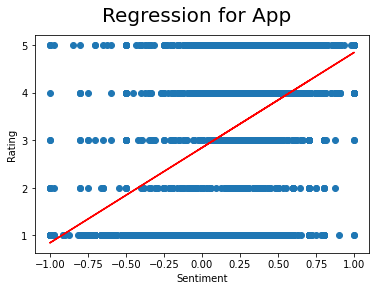

In [55]:
# Display the model
x = reviews_df[reviews_df["topic"] == "A"]["sent_pol"]
plt.scatter(x, y)
plt.suptitle("Regression for App", fontsize=20)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")
plt.plot(x, model.coef_*x + model.intercept_, "r") 

In [56]:
topic_dict = {
    "A" : "App/UI/Features",
    "O" : "Other aspects",
    "F" : "Fees",
    "D" : "Deposit/Withdrawals/Transaction Handling",
    "R" : "Registration/Verification Process",
    "C" : "Customer Service",
    "T" : "Trust and Company Reputation"
}

In [57]:
reviews_df["topic"].unique()

array(['O', 'A', 'C', 'F', 'R', 'D'], dtype=object)

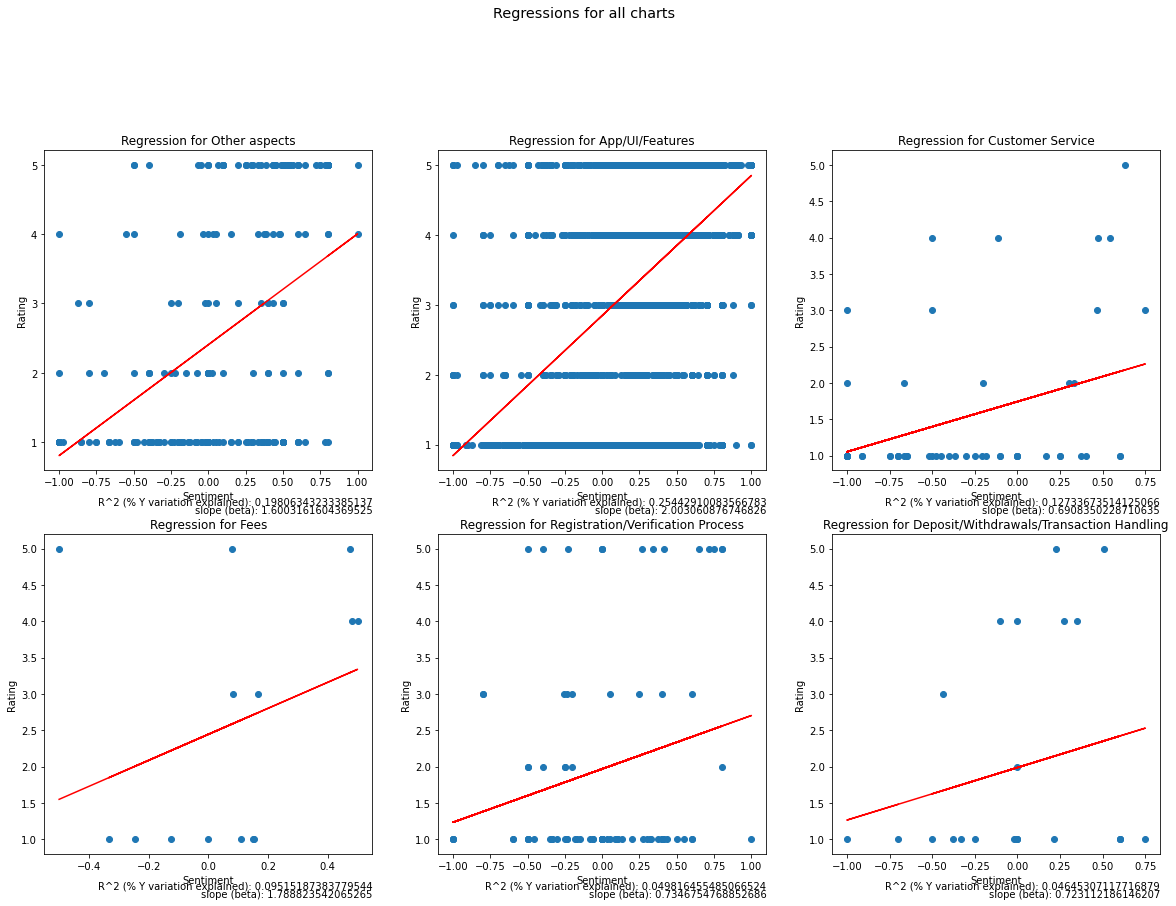

In [58]:
# Now we plot for all the topic
fig = plt.figure(figsize=(20,20))
st = fig.suptitle("Regressions for all charts", fontsize="x-large")

idx = 1
for key in reviews_df["topic"].unique():
    y = reviews_df[reviews_df["topic"] == key]["rating"]
    x = reviews_df.loc[reviews_df["topic"] == key].loc[:, ["sent_pol"]]
    model.fit(x, y)
    score = model.score(x, y)
    x = reviews_df[reviews_df["topic"] == key]["sent_pol"]
    curr_plot = fig.add_subplot(3, 3, idx)
    curr_plot.scatter(x, y)
    curr_plot.set_title(f"Regression for {topic_dict[key]}")
    curr_plot.set_xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
    curr_plot.set_ylabel("Rating")
    curr_plot.plot(x, model.coef_*x + model.intercept_, "r") 
    curr_plot.annotate(f"slope (beta): {model.coef_[0]}",
            xy = (1.0, -0.125),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    curr_plot.annotate(f"R^2 (% Y variation explained): {score}",
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    idx = idx + 1

fig.show()
    

In [59]:
reviews_df.to_csv("sent_normal.csv")

### Analysis

1. Strongest overall fit/slope seems to do with deposits/withdrawals, followed by customer service and fees - This indicates that a good withdarwal experience has a significant impact on the overall rating of the customer
2. Weakest overall fit/slope seemes to relate to registration/verification process - this means that a poor verification/registration process is not a significant factor influencing the the reviews.



In [60]:
# Count number of sentiment in each category
count_df = {"topic" : [], "pos_count" : [], "neg_count": []}
for key in sentiment_df["prediction"].unique():
    pos_df = sentiment_df.loc[(sentiment_df["is_positive"] == True) & (sentiment_df["prediction"] == key)] #! .loc returns boolean index error
    neg_df = sentiment_df.loc[(sentiment_df["is_positive"] == False) & (sentiment_df["prediction"] == key)] #! .loc returns boolean index error
    count_df["topic"].append(key)
    count_df["pos_count"].append(pos_df.shape[0])
    count_df["neg_count"].append(neg_df.shape[0])
count_df = pd.DataFrame(count_df)
count_df.head(100)
# df[(df["prediction" )]

,topic,pos_count,neg_count
0,O,130,111
1,A,2529,1013
2,C,15,39
3,F,9,5
4,R,35,51
5,D,9,14


In [61]:
# perform regressionbetween pos count/neg count and the rating? 
#! For got to stash rating information. -> y = rating X = each feature's sentiment score? so each sentence's labelled sentiment score (Do for each topic)

# Need to average sentiment for topic per person () e.g. Review X - topic 1 : setnence 1 = 0.5, sentence  2 = 0.3, overall sentiment for s = 0.4
# Not fair as that gives higher weighting to longer reviews - e.g. 999 good reviews 1 setennce, 1 bad review with 1000 sentences.
# Extra: 100 words - 20 words on app, 10 words on 
# Y = Rating, X = Sentiment for topic between -1 and 1 (6 columns of xs - A, O, T), each point (unit of analysis) = review (not single sentence)

# IF you can find something interesting then just stop -> and find supplementary analysis to support the findings.
# Compare this to other finance apps.

#TODO: 

new_long.loc[new_long["prediction"] == "D"]["content"]

155      Been using Rh for two years now nothing but a ...
650       Had to go through 3 different departments onl...
1016      I dropped $20 then $8, standard 2 to 6 days t...
1172      Almost positive they round numbers in their f...
1324            Wish you could hold multiple account types
                               ...                        
13052     Wait for my videos how bad etoro holding my m...
13217     You need to send them USD and wait 7 days for...
13237     won't verify your acc unless you send them a ...
13282     In just 4 days I received my money, though it...
13287     I could give 0 rating if I could and let me k...
Name: content, Length: 151, dtype: object